- I've immediately realised that word-based LMs or LMs without character-based modeling won't be useful for this. This is an unmasking task but the SOTA BERT is not useful at all since its tokenisation is with word piece tokens. I had the plan that at the end I'll train a BERT with character tokenisation from scratch since there is enough English dataset on the web but I was lazy in the end.
- I wanted to start with character-based modeling and not with DL since the specific training data is not too large.
- I wanted to start with unsmoothed maximum-likelihood character level language models
- Somewhere at around half time I've found the source of the corrupted text. I guess the "anything from the web" in the task description is not meant for the usage of it https://www.gutenberg.org/files/2895/2895-h/2895-h.htm
- I was lazy to try reverse N-gram models also
- Furthermore, I had in the pipeline another DL models: character-based Seq2seq (encoder-decoder) models with RNN or CNN, or even a full Transformer (not just its encoder aka BERT could go)
- At last, I had the idea to train a word2vec model with augmented corpus (with the corrupted versions of the words as well) but I've got stuck with possible handeling the OoV words...

In [ ]:
# imports

from collections import *
from random import random
from IPython.display import Image, display
import pydot
import pygtrie

In [ ]:
# mask function

def mask(token_list, stoch=0.0):
    masked_token_list = []
    for i in token_list:
        masked_i = ""
        if len(i) > 1:
            is_second_char = False
            for c in i:
                if is_second_char is True:
                    x = random()
                    if x > stoch:
                        c = '#'
                    is_second_char = False
                else:
                    is_second_char = True
                masked_i += c
        else:
            masked_i = i
        masked_token_list.append(masked_i)
    
    return masked_token_list

Data preparation. The most important that we keep 10% held out data for testing the performance ouf our models.

In [ ]:
TRAINING_TOKENS = []
with open('training_tokens.txt', 'r', encoding='utf-8') as f:
    for line in f:
        tok = line.strip()
        TRAINING_TOKENS.append(tok)

CORRUPTED_TOKENS = []
with open('corrupted_tokens.txt', 'r', encoding='utf-8') as f:
    for line in f:
        tok = line.strip()
        CORRUPTED_TOKENS.append(tok)

training_text = ' ' + ' '.join(TRAINING_TOKENS).lower()
TRAINING_TOKENS = training_text[1:].split(' ')
corrupted_text = ' ' + ' '.join(CORRUPTED_TOKENS).lower()
CORRUPTED_TOKENS = corrupted_text[1:].split(' ')

# naive validation dataset split
validation_percentage = 10
amount_of_validation_tokens = len(TRAINING_TOKENS) // validation_percentage

validation_tokens = TRAINING_TOKENS[:amount_of_validation_tokens]
validation_text = ' ' + ' '.join(validation_tokens).lower()
validation_tokens = validation_text[1:].split(' ')

masked_validation_tokens = mask(validation_tokens)
masked_validation_text = ' ' + ' '.join(masked_validation_tokens).lower()
masked_validation_tokens = masked_validation_text[1:].split(' ')

discounted_training_tokens = TRAINING_TOKENS[amount_of_validation_tokens:]
discounted_training_text = ' ' + ' '.join(discounted_training_tokens).lower()
discounted_training_tokens = discounted_training_text[1:].split(' ')

Validation that masking works.

In [ ]:
mask(validation_tokens[:10])

['p#e#a#e',
 'm#s#',
 'o#',
 't#e',
 'a#v#n#u#e#',
 'r#c#r#e#',
 'i#',
 't#i#',
 'b#o#',
 'r#a#l#']

So, I wanted statistical LM.

## Language Model definition
A LM consist of a finite set vocabulary of tokens $\mathcal{V}$, and a fucntion $p(x_1,x_2,\dots x_n)$ such that:

1. $\forall \langle x_1 \dots x_n \rangle \in \mathcal{V}, p(x_1,x_2,\dots x_n) \ge 0$
2. In addition $\sum_{\langle x_1 \dots x_n \rangle \in \mathcal{V}}{p(x_1,x_2,\dots x_n)} = 1$

Hence, $p(x_1,x_2,\dots x_n)$ is a probability distribution over the sentences in $\mathcal{V}$.

In fact, there are 2 important equations and an estimation method regarding sentence/sequence modeling.

## Chain rule of probability
$$p(x_1,x_2,\dots x_n)=p(x_1^n)=p(x_1)p(x_2|x_1)p(x_3|x_1^2) \dots p(x_n|x_1^{n-1})=\prod_{i=1}^{n}{p(x_i|x_1^{i-1})}$$

## Markov assumption
The probability of a token depends only on the previous $(N-1)$ tokens:

$$p(x_n|x_1^{n-1}) \approx p(x_n|x_{n-N+1}^{n-1})$$

Hence, the joint probability $p(x_1^n)$ is approximated by $\prod_{i=1}^{n}{p(x_i|x_{i-N+1}^{i-1})}$. This is called an N-gram model or (N-1) order Markov model.

## Maximum Likelihood Estimation
We get the MLE for the parameters of an N-gram model by getting counts from a corpus, and normalizing the counts so that they lie between 0 and 1.

#### Log-likelihood maximization
$$\log{p(\mathbf{x}_{train})}=\sum_{i=1}^{D}{\log{p(x_i|x_{i-N+1}^{i-1})}} \rightarrow \max$$

In fact, estimates of parameters in the following forms are MLE:

$$p(x_i|x_{i-N+1}^{i-1})=\frac{c(x_{i-N+1}^{i})}{\sum_{x_i}{c(x_{i-N+1}^{i})}}=\frac{c(x_{i-N+1}^{i})}{c(x_{i-N+1}^{i-1})}$$

I've found a skeleton of the solution with character-based tokenization on the web.

In [ ]:
# Taken from Yoav https://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139

def train_char_lm(fname, order):
    #data = file(fname).read()
    data = fname
    lm = defaultdict(Counter) # quite advanced dictionary class
    pad = "~" * order
    data = pad + data
    
    for i in range(len(data)-order):
        history, char = data[i:i+order], data[i+order]
        lm[history][char] += 1 # this is the count of the N-gram (the nominator)
    
    for history in list(lm):
        chars_list = list(lm[history])
        if (len(chars_list) == 1) and (chars_list[0] == ' '):
            #print("warning: order "+str(order)+" lm has a prefix of: "+str(history)+" followed by the space char with 1.0 prob")
            pass
    
    def normalize(counter):
        s = float(sum(counter.values()))
        return [(c, cnt/s) for c, cnt in counter.items()] # the denominator, the marginalizing equation
    
    outlm = {hist : normalize(chars) for hist, chars in lm.items()}
    return outlm

Let's try a trigram model first.

In [ ]:
lm = train_char_lm(training_text, order=2)

Let's check some conditional probabilites. Yoav added a start token '~' into the dataset to have a state where free text generation could start according to data. (actually it's nothing usesful for us)

In [ ]:
lm['~~'], lm['he']

([(' ', 1.0)],
 [(' ', 0.6017507767234864),
  ('r', 0.1476194474766983),
  ('d', 0.01765471492148795),
  ('y', 0.04889159459232513),
  ('m', 0.028948694264841715),
  ('n', 0.061361155428667394),
  ('a', 0.02997732807120665),
  ('s', 0.02004786296078596),
  ("'", 0.0027500209925266604),
  ('l', 0.009992442690402217),
  ('c', 0.0005458056931732303),
  ('e', 0.0054580569317323035),
  ('i', 0.019921907800822907),
  ('w', 0.00037786547988915946),
  ('t', 0.0026030733059030984),
  ('o', 0.0012385590729700226),
  ('v', 0.00010496263330254429),
  ('p', 8.397010664203544e-05),
  ('b', 0.00016794021328407087),
  ('q', 4.198505332101772e-05),
  ('z', 0.0004618355865311949)])

It's very interesting that in many cases the most probable n-gram yields the space character. Our n-grams correctly capture the word endings (ant their probabilities in data).

In [ ]:
lm = train_char_lm(training_text, order=1)
sorted(lm['n'], key=lambda x: x[-1], reverse=True) # very interesting

[(' ', 0.25182895753530504),
 ('d', 0.19899057984118895),
 ('g', 0.11954395252108439),
 ('t', 0.08558699261840959),
 ('e', 0.08414026665789863),
 ('o', 0.07075805152317227),
 ('c', 0.03281437519522581),
 ('s', 0.03209101221497033),
 ('i', 0.02640274877932497),
 ("'", 0.01874989724957667),
 ('a', 0.017895013727456558),
 ('y', 0.015470103736827395),
 ('k', 0.009346178506255446),
 ('n', 0.007973432850543345),
 ('l', 0.007669291597481382),
 ('u', 0.0055320827921811035),
 ('f', 0.004381278050865569),
 ('v', 0.0033455537836815886),
 ('j', 0.0015782465023755899),
 ('q', 0.001117924605849376),
 ('r', 0.0010686044026501388),
 ('m', 0.0008959836914528088),
 ('h', 0.0008137833527874135),
 ('p', 0.00048498199812583225),
 ('w', 0.00046854193039275324),
 ('b', 0.0004603218965262137),
 ('z', 0.00031236128692850216),
 ('x', 0.000279481151462344)]

Just looking at the same fenomenon. For us it is going to be important since for our masked-value predictions we do not allow to predict a space character.

In [ ]:
lm = train_char_lm(training_text, order=2)
sorted(lm['en'], key=lambda x: x[-1], reverse=True) # inheriting...

[(' ', 0.38686337685828953),
 ('t', 0.2949522356000226),
 ('c', 0.07331411452150811),
 ('d', 0.06647447854841444),
 ('e', 0.048838392402916736),
 ('s', 0.032106720931547116),
 ('g', 0.029110847323497824),
 ('i', 0.01577073088010853),
 ('o', 0.015544627211576508),
 ('r', 0.005087332541970494),
 ("'", 0.00463512520490645),
 ('l', 0.00463512520490645),
 ('a', 0.004295969702108417),
 ('n', 0.004182917867842406),
 ('j', 0.003843762365044373),
 ('u', 0.003843762365044373),
 ('v', 0.0031089254423153014),
 ('z', 0.001300096094059126),
 ('y', 0.0009044146741280877),
 ('p', 0.0003391555027980329),
 ('h', 0.00022610366853202194),
 ('w', 0.00016957775139901646),
 ('m', 0.00016957775139901646),
 ('b', 0.00016957775139901646),
 ('f', 0.00011305183426601097)]

Yoav's sampling extended with my guarantee just to be sure the highest possible probability gets selected.

In [ ]:
def generate_letter(lm, history, order, stoch=True):
    history = history[-order:]
    dist = lm[history]
    dist = sorted(dist, key=lambda x: x[-1], reverse=True) # to be sure it's correct

    if stoch is False:
        for c, v in dist: 
            if c != ' ': return c

    x = random()
    for c, v in dist:
        x = x - v
        if x <= 0: return c # interesting sampling but correct

Yoav's free text generator. Starting from the state '~'.

In [ ]:
def generate_text(lm, order, nletters):
    history = "~" * order
    out = []
    for i in range(nletters):
        c = generate_letter(lm, history, order)
        history = history[-order:] + c
        out.append(c)
    return "".join(out)

Validation of the free text generator. LM is built on the whole training datased. Generation start at the state '~' then sampling follows the n-gram probability distributions.

In [ ]:
order = 7 # seems to be needed at this point

lm = train_char_lm(training_text, order=order)
print (generate_text(lm=lm, order=order, nletters=40))

 preface it is hardly sensible rest in m


Fun and it validates the power of the LM: every second (and just the second!) character of a word is #

In [ ]:
order = 7

lm = train_char_lm(corrupted_text, order=order)
print (generate_text(lm=lm, order=order, nletters=40))

 t#a# n#t# b#o# a#d t#e c#n#u#e# w#i#h h


Specific text generator version for unmasking our corrupt data.

In [ ]:
def unmask_text(lm, order, masked_text, stoch=True):
    history = ""
    out = []
    for i in masked_text:
        if i == '#':
            to_sample = True
            while(to_sample is True):
                c = generate_letter(lm, history, order, stoch=stoch)
                if c != ' ': # we don't want ' ' in a word
                    history = history[-order:] + c
                    out.append(c)
                    to_sample = False
        else:
            history = history[-order:] + i
            out.append(i)
    return "".join(out)

A bigram LM seems to be very week. Furthermore, I've realised at this point that I shouldn't be sampling but pick the most probable category.

In [ ]:
order = 1

lm = train_char_lm(training_text, order=order)
print(corrupted_text[:40])
for i in range(10):
    print (unmask_text(lm=lm, order=order, masked_text=corrupted_text[:40], stoch=True))

 t#a# n#t# r#c#l#s a# e#p#r#e#c# t#e p#s
 tsab ndth recllas at enpursesch tce pes
 tian neti rscrlys ar eepersenck tie pes
 tsan ngth rocolis an evprrsewct tre pas
 toay ndte rdcalis as elpireeach the pes
 tial ntth rtcolls ad enpornerch the prs
 tiar ndto ractlds an enprrsevcu tae pes
 tyar ndth rechlgs as evprreerck the pls
 tral noth racklas ai ewplrsetch the pis
 tias nito rscrlls ag empereesca tye pls
 tuan ntth recelis an evpareerci the pes


Picking the most probable category seem to yield some improvement.

In [ ]:
order = 1

lm = train_char_lm(training_text, order=order)
print(corrupted_text[:40])
print (unmask_text(lm=lm, order=order, masked_text=corrupted_text[:40], stoch=False))

 t#a# n#t# r#c#l#s a# e#p#r#e#c# t#e p#s
 than ndth recoles an erpereerco the pes


I've implemented a mix of N-gram LMs. At each prediction I'm trying with the highest order model as possible, if that doesn't model the given prefix (due that it's been unseen in the training data) then I've implemented a (so called) stupid back-off to a lower order N-gram. In theory it could go down to unigrams (in case of a very small dataset) but in our case bigrams cover all the possible prefixes.

In [ ]:
def generate_letter_with_mixed_models(lm, history, order, stoch=True, indiv=False):
        history = history[-order:]
        
        if (indiv is True) and (len(history) > 2): # cut prefix before a space characer i.e., treat words individually
            for i in range(len(history)-2, 0, -1): # it is valid since the last character cannot be a space one, and the first is ok to be that
                if history[i] == ' ':
                    history = history[i:] # keep the space character as well (it is defined then as a standalone word)
                    order = len(history)
                    break
        
        for i in range(order, 0, -1):
            temp_lm = lm[str(i)]
            temp_history = history[-i:]
            if temp_history in temp_lm:
                dist = temp_lm[temp_history]
                if (len(dist) == 1) and (dist[0][0] == ' '):
                    #print("warning: order "+str(i)+" lm has a prefix of: "+str(temp_history)+" followed by the space char with 1.0 prob -> continue")
                    continue
                dist = sorted(dist, key=lambda x: x[-1], reverse=True) # to be sure

                if stoch is False:
                    for c, v in dist: 
                        if c != ' ': return (c, i)

                x = random()
                for c, v in dist:
                    x = x - v
                    if x <= 0: return (c, i) # interesting sampling but correct
        
        # Oops, we've ran out of options
        print("oops")
        return (None, None)

In [ ]:
def unmask_text_with_mixed_models(lm, order, masked_text, stoch=True, indiv=False):
    history = ""
    out = []
    out_model_order = []
    for i in masked_text:
        if i == '#':
            to_sample = True
            while(to_sample is True):
                c, model_order = generate_letter_with_mixed_models(lm=lm, history=history, order=order, stoch=stoch, indiv=indiv)
                if c != ' ': # we don't want ' ' in a word
                    history = history[-order:] + c
                    out.append(c)
                    out_model_order.append(str(model_order))
                    to_sample = False
        else:
            history = history[-order:] + i
            out.append(i)
            out_model_order.append(i)
    return ("".join(out), "".join(out_model_order))

Let's have a mixed model up to a 9 order LM.

In [ ]:
order = 9

language_model = {}
for i in range(1, order+1): # based on available data we don't have to deal with unigrams
    language_model[str(i)] = train_char_lm(training_text, order=i)

I've played with several orders but we're just not good enough for the corrupted text. 

In [ ]:
length = 400

prediction, model_order = unmask_text_with_mixed_models(lm=language_model, order=order, masked_text=corrupted_text[:length], stoch=False, indiv=False)

print(corrupted_text[:length])
print(model_order)
print(prediction)

 t#a# n#t# r#c#l#s a# e#p#r#e#c# t#e p#s#e#g#r# w#r# s#n# f#r t# c#m# u# i# t#e b#w a#d s#e a f#n# s#g#t i# w#s v#r# d#r# o#e c#u#d n#t f#l#o# w#t# t#e e#e t#e s#r#a#e o# t#e s#a m#r# t#a# f#f#y y#r#s i# a#y d#r#c#i#n i# d#m#e# a#a# a#d b#c#m# l#s# t# s#g#t a# a#o#t t#a# d#s#a#c# f#o# u# b#t i# y#u p#t#e#t#y g#z#d i#t# t#e d#r#n#s# a l#t#l# w#i#e t#e#e w#s a s#r# r#w#r# f#r y#u p#e#e#t#y a q#a#t#r
 t2a4 n7t9 r5c6l3s a5 e7p3r5e5c4 t4e p8s2e4g1r3 w6r8 s9n9 f8r t9 c4m6 u4 i5 t8e b9w a4d s8e a f6n4 s5g2t i5 w8s v3r5 d8r8 o5e c4u5d n4t f7l5o4 w7t9 t9e e9e t3e s7r9a2e o5 t8e s9a m3r5 t3a4 f7f2y y4r4s i6 a7y d9r9c9i9n i9 d7m2e3 a6a4 a6d b8c8m9 l9s5 t8 s4g2t a5 a8o5t t8a6 d8s9a6c5 f5o5 u7 b6t i6 y6u p9t4e5t5y g4z2d i5t3 t3e d7r8n2s4 a l7t9l9 w9i9e t9e9e w5s a s5r7 r4w5r7 f6r y7u p3e5e2t4y a q5a7t9r
 that noth rockles an enporterco the prstepgers were sent for th comp up in the bew and ste a fond stgot it whs very dire ofe churd not fillow with the exe the straace of the sta marv that foffy yor

Let's quantify how good we're with a score function which yields us the prediction accuracy (correct/total predictions).

In [ ]:
# score function

def score(ground_through_token_list, predicted_token_list, character_based=True):
    token_index = 0
    accurate_prediction = 0
    total_prediction = 0
    
    for token in predicted_token_list:
        if len(token) > 1:
            if character_based is True:
                character_index = 0
                for character in token:
                    if character_index % 2 == 1:
                        if character == ground_through_token_list[token_index][character_index]:
                            accurate_prediction +=1
                        total_prediction +=1
                    character_index += 1
            else:
                if token == ground_through_token_list[token_index]:
                    accurate_prediction +=1
                total_prediction +=1
        token_index += 1
    
    return accurate_prediction/total_prediction

Score function validation

In [ ]:
score(validation_tokens, mask(validation_tokens, stoch=0.33), character_based=True)

0.32961783439490444

A mixture up to order 5 LM seems to perform the best on the validation dataset (build on the training text).

In [ ]:
order = 5
language_model = {}
for i in range(1, order+1): # based on available data we don't have to deal with unigrams
    language_model[str(i)] = train_char_lm(discounted_training_text, order=i)

prediction, model_order = unmask_text_with_mixed_models(lm=language_model, order=order, masked_text=masked_validation_text, stoch=False, indiv=False)
prediction_tokens = prediction[1:].split(' ')

length = 50
print(validation_text[:length])
print(model_order[:length])
print(prediction[:length])

score(validation_tokens, prediction_tokens, character_based=True), score(validation_tokens, prediction_tokens, character_based=False)

 preface most of the adventures recorded in this b
 p2e4a3e m5s5 o5 t5e a5v2n3u4e3 r4c5r5e5 i5 t5i5 b
 presare mast of the asvinguiet recorded in this b


(0.365077878285072, 0.34295724222585927)

It (37% accuracy) is an order of magnitude better than the random guess (~3%) but that's the best.
I had the feeling that there is more info due to the structure of the (corrupted) data, so I wanted to try a bit more algorithmic approach. I wanted to build a dictionary on the training data indexed by the odd characters (which are never masked). I felt it's possible since the is a finite number of combination belonging to each index and due to the fact that the data is an NL text -> there are even less combinations. Furthermore NL words are mostly suffixes of each other. I just had to find a data structure to implement efficiently this dictionary. That is a suffix trie. So, I've taken the training text, and masked it. I stored the masked words in the trie and the value corresponding the keys is another dictionary of all the possible reincarnations of that masked word appearing in the training text (with their counts to support the decision about their probabilities according the text). So extremely easy.

First, start with a visualisation of this trie. I've taken the code form the Internet.

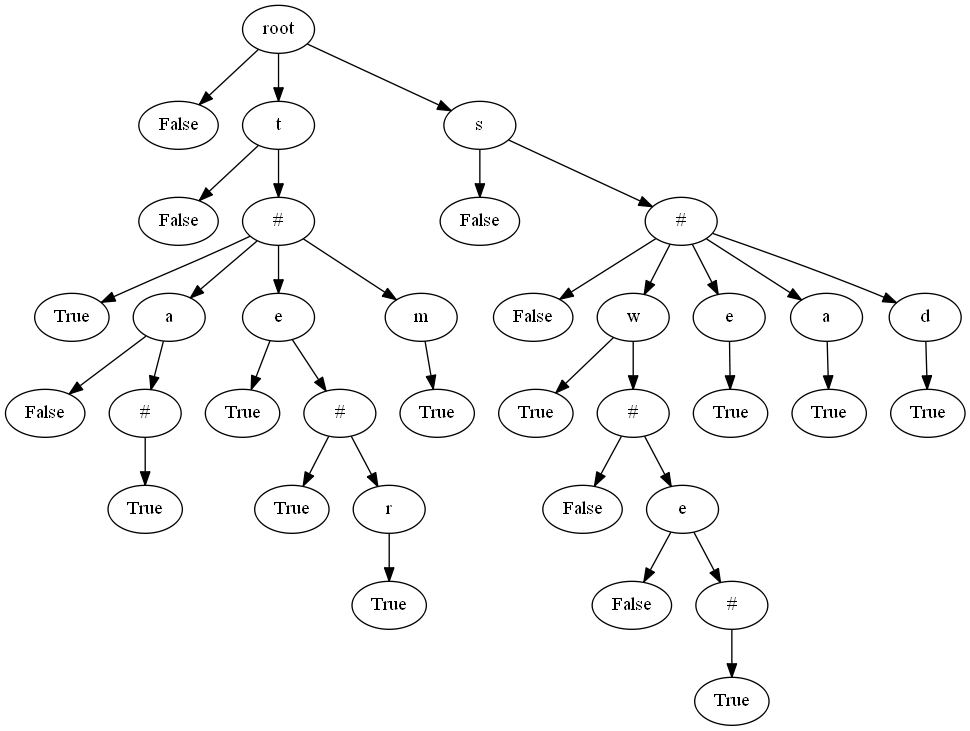

In [ ]:
# Taken from https://github.com/ahmednooor/trie_graph

def view_pydot(pdot):
    plt = Image(pdot.create_png(), width = 600, height = 300)
    display(plt)

# function to return a new dict template
def struct():
    struct = {
        'iw': 'False'
    }
    return struct

file_text = 't#\nt#a#\nt#a#\nt#e#\nt#e#r\nt#e\nt#\nt#m\ns#w\ns#w#e#\ns#e\ns#a\ns#d\n'

# trie making stuff happening (hard to explain)
tmp_s = struct()
root = tmp_s
for c in file_text:
    if c != '\n':
        if c not in tmp_s:
            tmp_s[c] = struct()
        tmp_s = tmp_s[c]
    elif c == '\n':
        tmp_s['iw'] = 'True'
        tmp_s = root
        cur_word = []

# converting and saving the trie to dot language decision tree graph using pydot
# // code taken and modified from stackoverflow (https://stackoverflow.com/questions/13688410/dictionary-object-to-decision-tree-in-pydot)
rt = {'root': root}
counter = 0
def draw(parent_name, child_name):
    global counter
    counter += 1
    p_n = parent_name
    c_n = child_name
    graph.add_node(pydot.Node(p_n, label=parent_name.split('_')[0]))
    graph.add_node(pydot.Node(c_n, label=child_name.split('_')[0]))
    edge = pydot.Edge(p_n, c_n)
    graph.add_edge(edge)

def visit(node, parent=None):
    global counter
    for k,v in node.items():
        if isinstance(v, dict):
            # We start with the root node whose parent is None
            # we don't want to graph the None node
            k = k + '_' + str(counter)
            if parent:
                draw(parent, k)
            visit(v, k)
        else:
            # drawing the label using a distinct name
            v = v + '_' + str(counter)
            draw(parent, v)

graph = pydot.Dot(graph_type='digraph')
visit(rt)
view_pydot(graph)

Building the trie is so easy.

In [ ]:
def build_trie(token_list):
    t = pygtrie.CharTrie()
    
    for i in token_list:
        masked_i = ""
        if len(i) > 1:
            is_second_char = False
            for c in i:
                if is_second_char is True:
                    c = '#'
                    is_second_char = False
                else:
                    is_second_char = True
                masked_i += c
        else:
            masked_i = i

        if masked_i in t:
            if i in t[masked_i]:
                t[masked_i][i] += 1
            else:
                t[masked_i][i] = 1    
        else:
            t[masked_i] = {i:1}
    
    return t

In [ ]:
t = build_trie(token_list=discounted_training_tokens)

So, these are all the words (with their counts) which are mapped to that masked word based on the training text.

In [ ]:
t['t#a#']

{'that': 5552,
 'than': 482,
 'tear': 15,
 'twas': 4,
 'trap': 6,
 'team': 3,
 'thar': 3,
 'trav': 1}

This is the way how we're going to use the trie to unmask a corrupted text.

In [ ]:
t.longest_prefix('t#a#o#s'), t.longest_prefix('t#1233'), t.longest_prefix('z#p#y#')

(('t#a#o#': {'teapot': 2}),
 ('t#': {'to': 10168, 'td': 2, 'tf': 1, 'te': 1, 'th': 2}),
 ('z#p#y#': {'zephyr': 1}))

Let's try it on the masked validation text. It contains only 2 out of vocabulary words (not even a prefix of them is present in the trie).

In [ ]:
prediction_tokens = []
for i in masked_validation_tokens:
    if t.longest_prefix(i).key is not None:
        prediction_tokens.append(list({k: v for k, v in sorted(t.longest_prefix(i).value.items(), key=lambda item: item[1], reverse=True)})[0])
    else:
        print("OOV: "+i)
        prediction_tokens.append(i)

OOV: z#p#y#
OOV: z#b#a#


This is how good the predicted words look like

In [ ]:
prediction_tokens[:10]

['prepare',
 'most',
 'of',
 'the',
 'adventures',
 'recorded',
 'it',
 'this',
 'book',
 'really']

The unmasking of the first word is wrong due to the fact that the word prepare is more frequent in the text.

In [ ]:
t.longest_prefix('p#e#a#e'), t.longest_prefix('i#')

(('p#e#a#e': {'peerage': 1, 'preface': 3, 'prepare': 7}),
 ('i#': {'it': 6454, 'in': 6435, 'if': 1042, 'is': 3745, 'ii': 19, 'iv': 7, 'ix': 2}))

Score has been improved.

In [ ]:
score(validation_tokens, prediction_tokens, character_based=True), score(validation_tokens, prediction_tokens, character_based=False)

(0.8623553640625423, 0.8105053191489362)

Let's apply it on the corrupted text.

In [ ]:
recovered_tokens = []
for i in CORRUPTED_TOKENS:
    if t.longest_prefix(i).key is not None:
        recovered_tokens.append(list({k: v for k, v in sorted(t.longest_prefix(i).value.items(), key=lambda item: item[1], reverse=True)})[0])
    else:
        print("OOV: "+i)
        recovered_tokens.append(i)

OOV: z#r#
OOV: z#l#s
OOV: z#l#s
OOV: z#l#s
OOV: z#l#
OOV: z#g
OOV: z#g
OOV: z#m#e#i


Looks good

In [ ]:
' '.join(recovered_tokens)[:2000]

"that note recalls as experience the passengers were sent for to come up it the bow and she a find sight it was very dark one could not fellow with the eye the surface of the sea more that fifty yards it any direction it damned away and became last to sight as about that distance from up but it you patiently gazed into the darkness a little while there was a sort reward for you presently a quarter of a mile away you would she a building solos of explosion of light of the water a flash so sudden and so astonishing brilliant that it would make you catch your breath they that book of light would instantly extent itself and take the corkscrew state and imposing length of the f sea serpent with every curve of its body and the break spreading away from its head and the wake following behind its this clothed it a french splendor of living fire and my but it was coming as a lightning gain almost before you could think this monster of light fifty feet long would go flaying and shopman by and su

Let's take the full training data for buliding the trie then we're done.

In [ ]:
t = build_trie(token_list=TRAINING_TOKENS)

recovered_tokens = []
for i in CORRUPTED_TOKENS:
    if t.longest_prefix(i).key is not None:
        recovered_tokens.append(list({k: v for k, v in sorted(t.longest_prefix(i).value.items(), key=lambda item: item[1], reverse=True)})[0])
    else:
        print("OOV: "+i)
        recovered_tokens.append(i)

with open('recovered_tokens.txt', 'w') as f:
    f.writelines(["%s\n" % item  for item in recovered_tokens])

OOV: z#r#
OOV: z#l#s
OOV: z#l#s
OOV: z#l#s
OOV: z#l#
OOV: z#g
OOV: z#g
OOV: z#m#e#i
